# Introducción
Un servicio de venta de autos usados está desarrollando una aplicación para atraer nuevos clientes. Gracias a esta app, se puede averiguar rápidamente el valor de mercado de tu coche. Se tiene acceso al historial: especificaciones técnicas, versiones de equipamiento y precios.


# Objetivo

Crear un modelo que determine el valor de mercado. A la empresa le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento


Para realizar esta tarea será necesario entrenar distintos modelos. Se debe empezar por un modelo de regresión lineal que funja como pruba de cordura. La métrica que se utilizará como base de comparación será la raiz del error cuadrático medio (RECM). Los modelos a comparar serán Bosque aleatorio y modelo basado en el descenso del gradiente. 

- Regresión Lineal.
- Bosque aleatorio.
- Modelo del descenso del gradiente con LightGBM


## Descripción preliminar de los datos

Será útil presentar la descripción básica de cada modelo.

- `DateCrawled` — fecha en la que se descargó el perfil de la base de datos
- `VehicleType` — tipo de carrocería del vehículo
- `RegistrationYear` — año de matriculación del vehículo
- `Gearbox` — tipo de caja de cambios
- `Power` — potencia (CV)
- `Model` — modelo del vehículo
- `Mileage` — kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
- `RegistrationMonth` — mes de matriculación del vehículo
- `FuelType` — tipo de combustible
- `Brand` — marca del vehículo
- `NotRepaired` — vehículo con o sin reparación
- `DateCreated` — fecha de creación del perfil
- `NumberOfPictures` — número de fotos del vehículo
- `PostalCode` — código postal del propietario del perfil (usuario)
- `LastSeen` — fecha de la última vez que el usuario estuvo activo

## Preparación de datos

### Descargar librerías

In [1]:
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder # Escalar nuestros valores
from sklearn.preprocessing import OrdinalEncoder

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

# Métricas de evaluación
from sklearn.metrics import mean_squared_error

# ParrilladaCV
from sklearn.model_selection import GridSearchCV

### Descargar Base de datos

In [2]:
df = pd.read_csv('/datasets/car_data.csv')

### Perspectiva inicial de los datos

In [3]:
# Obtener las dimensiones de nuestra tabla
df.shape
#Si eliminamos los ausentes nos quedarían 249 mil filas 

(354369, 16)

In [4]:
# Observar las primeras filas de la tabla
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [5]:
# Observar el tipo de datos y la presencia de valores ausentes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
# Calcular principales métricas para cada columna numérica
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
# Contar el número de valores ausentes por columna
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [8]:
# Calcular la cantidad de filas duplicadas
df.duplicated().sum()

262

In [9]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Observaciones iniciales**:

- Algunos columnas podrían tener el formato fecha.
- Tenemos variables numéricas y categoricas. Dentro de las categóricas, ninguna es ordinal y hay dos dicotómicas.
- Presencia de valores ausentes en 5 columnas categóricas.
- Tenemos precios iguales a cero.
- Hay valores duplicados pero son tan pocos entre una base de datos tan grande que posiblemente se deban sólo a coincidencias exactas. 
- Hay columnas que no se relacionan directamente con el valor del auto.

**Tratameinto:**

- Eliminar columnas inecesarias.
- Utilizar la columna `RegistrationYear` como un aproximado de la antiguedad de los autos.
- Investigar los valores extremos de la tabla.
- Eliminar valores ausentes. 

### Tratamiento de los datos

**Eliminar columnas inecesearias**

Se eliminarán las siguientes columnas cuyos valores no tengan relación directa o suficientemente directa con el modelo. La decisión se justifica por las siguientes razones: 
- `NumberOfPictures` es una columna inecesaria pues está consitutida exclusivamente de ceros.
- `RegristrationMonth` Aunque es posible que el precio de un auto dependa del mes en que ha sido comprado, sólo tenemos el dato del mes en que fue matriculado el auto *la primera vez que fue adquirido* y por ello no podemos utilizar el valor de este mes como un proxy del mes en que se vende *actualmente*. Más aún, no tenemos información de si los precios de los autos son ofertas actuales o pudieran ser autos ya vendidos a ese precio en diferentes meses. 
- `LastSeen`, `DateCreated` & `PostalCode` son información de los vendedores y no del auto en particular.
- `DateCrawled` podría ser útil sólo si el margen de descarga es grande. De tener una diferencia de tiempo pequeña, es posible que no aporte demasiado al modelo y sólo lo entorpezca. 
- `DateCrawled` Esta puede ser utilizada como aproximación de la antiguedad del vehículo por lo que, aunque no sea una medida exacta, sí puede ser útil al modelo.

In [10]:
# Cambiar "DateCrawled" al formato de fecha
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format = '%d/%m/%Y %H:%M')
# Diferencia de días
df['DateCrawled'].max() - df['DateCrawled'].min()

Timedelta('33 days 00:30:00')

Sólo se trata de 33 días. No será un diferenciador en las variables del modelo.

In [11]:
# Eliminar columnas inecesarias
df.drop(['DateCrawled', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCreated'], axis = 1, inplace = True)

In [12]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Mileage', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

**Observacion y tratamiento de los valores extremos de las tablas:**

Para poder visualizar la distribución de los valores extremos debemos seleccionar las variables numéricas del marco de datos para después graficarlas.

In [13]:
# Crear una lista de las variables numéricas
numericas = ['Price', 'RegistrationYear', 'Power', 'Mileage']

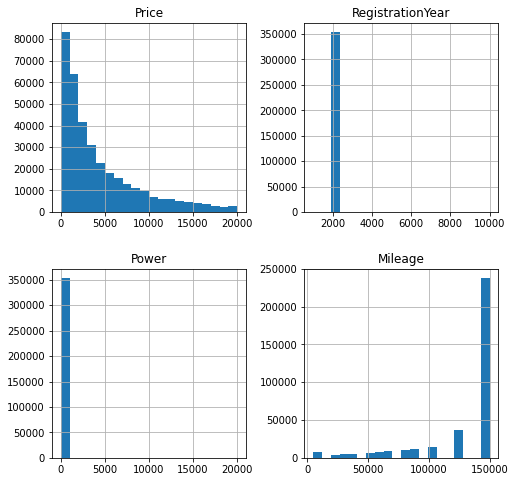

In [14]:
# Graficar cada variable
df.loc[:,numericas].hist(bins = 20, figsize=(8,8));

El amplio rango en el eje de las x en algunos gráficos indica que hay al menos un valor con datos muy alejados. Por ejemplo, autos con un año de registro de alrededor del año 10,000 o autos con 20,000 CV (que es la potencia en la que rondan algunos trenes). El precio también presenta varios valores cercanos a cero o incluso cero. El kilometraje parece estar dentro de las medidas posibles.

Para tratar cada una de las tablas escogeremos los valores que entren dentro de los rangos posibles.

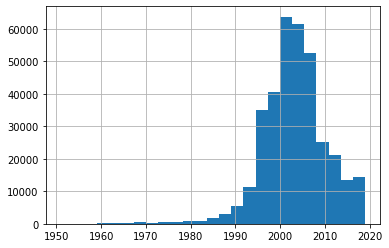

In [15]:
# Observar la distribución de los valores posibles
df.query('RegistrationYear > 1950 and RegistrationYear < 2023')['RegistrationYear'].hist(bins=25);

Estamos buscando automóviles que con base en sus características se vendan en el mercado para su uso. Autos clásicos o demasiado viejos no serán útiles para nuestro análisis porque bien podrían pertenecer a otro tipo de mercado. como se observa, la cantidad de autos comienza a ser importante para los autos de años posteriores a 1990 y por supuesto, a antes de 2020.

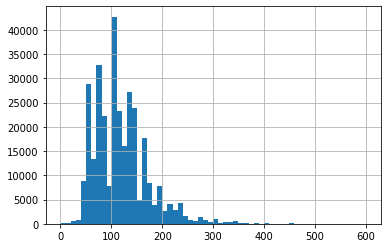

In [16]:
# Observar la distribución de los valores posibles
df.query('Power > 0 and Power < 600')['Power'].hist(bins=60);

Los caballos de vapor mínimos para un auto son de 60 CV mientras 2000 ya es un límite bastante extricto para un auto. La gráfica anterior muestra que la mayoría de los autos de nuestra tabla tienen máximo 450 CV. Un rango de entre 50 a 300 CV se encuentra dentro de lo posible mientras mantiene la mayor cantidad de datos.

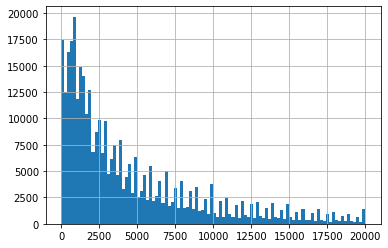

In [17]:
# Observar la distribución de los valores posibles
df.query('Price > -1 and Price < 20001')['Price'].hist(bins=100);

Tenemos una gran cantidad de autos cuyo valor está muy cercano a cero euros. Esto es extraño dado que eso sería un regalo y no una venta. Por lo tanto, no se espera que los valores de cero o muy cercanos a cero sean valores que deban ser tomados en cuenta. Si es posible, por su parte, que existan autos de segunda mano de alrededor de 20.000 euros.  Un rango de entre 500 a 20.000 debería ser suficiente.

In [18]:
# Aplciar todas las restricciones de manera conjunta
df_up = df.query('RegistrationYear > 1990 and RegistrationYear < 2023').query('Power > 50 and Power < 300').query('Price > 500 and Price < 20001')
df_up.shape

(267339, 10)

In [19]:
# Eliminar valores ausentes
df_a = df_up.dropna()
print(df_up.shape)
df_a.shape

(267339, 10)


(210202, 10)

In [20]:
# Mostrar primeras filas del nuevo conjunto
df_a.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no


Aún después de eliminar los valores ausentes aún tenemos suficientes datos para entrenar nuestros modelos. No obstante, hemos guardado la base de datos con valores ausentes ya que lightGBM y CatBoost pueden tratar con valores ausentes.

### Transformar valores de las columnas para el entrenamiento de los datos.

Para ofrecer la mejor comparación entre los modelos y determinar el mejor, debemos imprimir esfuerzos en que sean lo mejores posibles. Los modelos de regresión lineal y de árbol de decisión no procesan en automático las variables categóricas como lo hacen LightGBM o CatBoost por lo que es necesario ajustar las columnas de acuerdo con su naturaleza.

In [21]:
# Imprimir columnas restantes 
df_a.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Mileage', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

**Columnas numéricas:**

Ya se ha creado una lista para las columnas numéricas que será utilizada para escalar los valores.

**Columnas categóricas:**

Las columnas categóricas restantes son `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand`, `NotRepaired`. De las cuales, `Gearbox` y  `NotRepaired` podrían considerarse como dicotómicas. 

In [22]:
categoricas = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [23]:
# Contar número de características por categoría.
for i in categoricas:
    print(i, df_a[i].unique().size)

VehicleType 8
Gearbox 2
Model 245
FuelType 7
Brand 38
NotRepaired 2


Es posible usar OHE para todas las columnas excepto para `Model` y `FuelType`. En estos casos, la codificación ordinal será una mejor opción.

In [24]:
#Variables numéricas a escalar
num =  ['RegistrationYear', 'Power', 'Mileage']
# Variables categóricas a modificar con OHE {ctgs = categorías}
ctgs_ohe = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']
# Variables categóricas a modificar con OrdinalEncoder {enc = OrdinalENCoder}
ctgs_enc = ['Model', 'Brand']

### Dividir el conjunto de datos en conjunto de entrenamiento y prueba

In [25]:
# Dividir los conjuntos
train_dfa, test_dfa = train_test_split(df_a, random_state=24601, test_size=0.3)
# Dividirlos objetivos de las características
x_train_dfa = train_dfa.drop(['Price'], axis = 1)
y_train_dfa = train_dfa['Price']

# Dividir objetivos y caracter+isticas del conjunto de prueba
x_test_dfa = test_dfa.drop(['Price'], axis= 1)
y_test_dfa = test_dfa['Price']

**Escalar todas las variables numéricas**

Primero escalaremos los modelos. Podemos usar una función para este paso y el tratamiento de OrdinalEncoder.

In [30]:
#Definir una  función para no repetir código
def optimus_prime(train, test, instancia, columnas):
    
    modificado = pd.DataFrame(instancia.fit_transform(train[columnas]), columns = columnas)
    new_train = pd.concat([train.drop(columns=columnas).reset_index(drop=True), modificado], axis = 1)

    modificado_test = pd.DataFrame(instancia.transform(test[columnas]), columns = columnas)
    new_test = pd.concat([test.drop(columns=columnas).reset_index(drop=True), modificado_test], axis = 1)

    return new_train, new_test

In [31]:
scaled_dfs = optimus_prime(x_train_dfa, x_test_dfa, StandardScaler(), num)
scaled_dfs[0].head()

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,RegistrationYear,Power,Mileage
0,sedan,manual,golf,gasoline,volkswagen,no,1.599407,0.957782,0.632179
1,sedan,manual,passat,petrol,volkswagen,no,-2.381552,-0.721268,0.632179
2,coupe,manual,astra,petrol,opel,no,-1.983456,-1.350912,0.632179
3,wagon,manual,passat,petrol,volkswagen,yes,-0.789168,0.013316,0.632179
4,coupe,manual,rx_reihe,petrol,mazda,no,0.007024,1.419521,-0.038000


In [32]:
scaled_dfs[1].head()

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,RegistrationYear,Power,Mileage
0,sedan,manual,stilo,petrol,fiat,no,-0.192024,-0.448423,0.632179
1,small,manual,ka,petrol,ford,no,0.405120,-1.350912,-0.976249
2,wagon,manual,laguna,petrol,renault,no,-0.590120,-0.091624,0.632179
3,wagon,manual,astra,petrol,opel,no,-0.789168,-0.490399,0.632179
4,sedan,auto,7er,petrol,bmw,yes,-1.386312,2.322010,0.632179


**Aplicar OrdinalEncoder a las columnas seleccionadas**

In [33]:
enc_dfs = optimus_prime(scaled_dfs[0], scaled_dfs[1], OrdinalEncoder(), ctgs_enc)
enc_dfs[0].head()

,VehicleType,Gearbox,FuelType,NotRepaired,RegistrationYear,Power,Mileage,Model,Brand
0,sedan,manual,gasoline,no,1.599407,0.957782,0.632179,114.0,36.0
1,sedan,manual,petrol,no,-2.381552,-0.721268,0.632179,168.0,36.0
2,coupe,manual,petrol,no,-1.983456,-1.350912,0.632179,40.0,24.0
3,wagon,manual,petrol,yes,-0.789168,0.013316,0.632179,168.0,36.0
4,coupe,manual,petrol,no,0.007024,1.419521,-0.038000,188.0,19.0


In [34]:
enc_dfs[1].head()

,VehicleType,Gearbox,FuelType,NotRepaired,RegistrationYear,Power,Mileage,Model,Brand
0,sedan,manual,petrol,no,-0.192024,-0.448423,0.632179,209.0,9.0
1,small,manual,petrol,no,0.405120,-1.350912,-0.976249,126.0,10.0
2,wagon,manual,petrol,no,-0.590120,-0.091624,0.632179,134.0,27.0
3,wagon,manual,petrol,no,-0.789168,-0.490399,0.632179,40.0,24.0
4,sedan,auto,petrol,yes,-1.386312,2.322010,0.632179,17.0,2.0


In [35]:
# Observar que las dimensiones sean correctas
enc_dfs[0].shape, enc_dfs[1].shape

((147141, 9), (63061, 9))

**Aplicar OHE a las columnas seleccionadas:**

En este paso, además de cambiar los datos debemos asegurar que cada característica de cada columna corresponda correctamente con su valor como variable dicotómica. A su vez, eliminamos la primera observación extraida de cada columna por ser redundante.

In [37]:
#Crear instancia
ohe = OneHotEncoder(sparse = False, drop = 'first')
#Crear nuevas columnas y nombrarlas
ohe_ambas = pd.DataFrame(ohe.fit_transform(enc_dfs[0][['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']]), columns = ['convertible','coupe','othertype','sedan','small' ,'suv' ,'wagon','manual', 'electric', 'gasoline', 'hybrid', 'lpg', 'otherfuel', 'petrol','NotRepaid'])
#Concatenar los resultados
x_train = pd.concat([enc_dfs[0].drop(columns = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']).reset_index(drop=True), ohe_ambas], axis = 1)
# Mostrar el nuevo DataFrame
x_train.head()

,RegistrationYear,Power,Mileage,Model,Brand,convertible,coupe,othertype,sedan,small,suv,wagon,manual,electric,gasoline,hybrid,lpg,otherfuel,petrol,NotRepaid
0,1.599407,0.957782,0.632179,114.0,36.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-2.381552,-0.721268,0.632179,168.0,36.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.983456,-1.350912,0.632179,40.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.789168,0.013316,0.632179,168.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.007024,1.419521,-0.038000,188.0,19.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [38]:
# Aplicar OHE al conjunto de prueba

#Crear nuevas columnas y nombrarlas
ohe_ambas_test = pd.DataFrame(ohe.transform(enc_dfs[1][['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']]), columns = ['convertible','coupe','othertype','sedan','small' ,'suv' ,'wagon','manual', 'electric', 'gasoline', 'hybrid', 'lpg', 'otherfuel', 'petrol','NotRepaid'])
#Concatenar los resultados
x_test = pd.concat([enc_dfs[1].drop(columns = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']).reset_index(drop=True), ohe_ambas_test], axis = 1)
# Mostrar el nuevo DataFrame
x_test.head()

,RegistrationYear,Power,Mileage,Model,Brand,convertible,coupe,othertype,sedan,small,suv,wagon,manual,electric,gasoline,hybrid,lpg,otherfuel,petrol,NotRepaid
0,-0.192024,-0.448423,0.632179,209.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.405120,-1.350912,-0.976249,126.0,10.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.590120,-0.091624,0.632179,134.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.789168,-0.490399,0.632179,40.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.386312,2.322010,0.632179,17.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [39]:
# Mostrar dimensiones de los nuevos marcos de datos
x_test.shape, x_train.shape

((63061, 20), (147141, 20))

## Entrenamiento del modelo 

### Regresión Lineal

In [40]:
%%time
# Crear instancia
linear = LinearRegression()
# Entrenar modelo
linear.fit(x_train, y_train_dfa)
#Predecir
linear_omens = linear.predict(x_train)
# Evaluar resultado
linear_rmse = mean_squared_error(y_train_dfa, linear_omens, squared = False)
linear_rmse

CPU times: user 160 ms, sys: 90.3 ms, total: 250 ms
Wall time: 198 ms


2489.5897235982734

In [41]:
%%time
linear_omens_test = linear.predict(x_test)

linear_rmse_test = mean_squared_error(y_test_dfa, linear_omens_test, squared=False)
linear_rmse_test

CPU times: user 27.7 ms, sys: 15.7 ms, total: 43.4 ms
Wall time: 10.9 ms


2489.834354018167

### Bosque Aleatorio

In [42]:
%%time
# Crear instancias de cada modelo a utilizar
bosque = RandomForestRegressor(random_state = 73)
# Crear directorio de los valores a combinar
hip_bosque = {'n_estimators':[1,2,5,7,10], 'max_depth':[1,2,5,7,10]} # Solicitamos un bosque de 1 árbol
#Crear parrilla de elementos
gs_bosque = GridSearchCV(bosque, hip_bosque, cv=5, scoring = 'neg_root_mean_squared_error')
# Entrenar el modelo con conjunto de entrenamiento
best_bosque = gs_bosque.fit(x_train, y_train_dfa)
#Mostrar los hiperparámetros del mejor modelo
best_bosque.best_params_, best_bosque.best_score_

CPU times: user 1min 33s, sys: 35.9 ms, total: 1min 33s
Wall time: 1min 33s


({'max_depth': 10, 'n_estimators': 10}, -1764.757420759563)

In [43]:
%%time
bosque_omens_test = best_bosque.predict(x_test)

bosque_rmse_test = mean_squared_error(y_test_dfa, bosque_omens_test, squared=False)
bosque_rmse_test

CPU times: user 89.6 ms, sys: 15 µs, total: 89.6 ms
Wall time: 99.7 ms


1758.0990771730205

### LightGBM

In [44]:
%%time
# Convertir los datos a formato lightGBM
train_data = lgb.Dataset(x_train, label = y_train_dfa)
test_data = lgb.Dataset(x_test, label = y_test_dfa)

# Establecer los parámetros
params = {
    'objective':'regression',
    'learning_rate':0.12,
    'num_leaves':61,
}
#Entrenar el modelo
gbm = lgb.train(params, train_data, num_boost_round=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 577
[LightGBM] [Info] Number of data points in the train set: 147141, number of used features: 18
[LightGBM] [Info] Start training from score 5535.566769
CPU times: user 2.89 s, sys: 35.8 ms, total: 2.93 s
Wall time: 2.95 s


In [45]:
%%time
#Hacer predicciones
omens_gbm = np.round(gbm.predict(x_train))
omens_gbm_test = np.round(gbm.predict(x_test))

CPU times: user 2.4 s, sys: 7.71 ms, total: 2.41 s
Wall time: 2.4 s


In [46]:
# Evaluar el modelo
gbm_rmse = mean_squared_error(y_train_dfa, omens_gbm, squared=False)
gbm_rmse

1448.714581861209

In [47]:
# Evaluar modelo conjunto prueba
gbm_rmse_test = mean_squared_error(y_test_dfa, omens_gbm_test, squared=False)
gbm_rmse_test

1502.9195782971067

In [48]:
%%time
# Evaluar el modelo con otros hiperparámetros
params2 = {
    'objective':'regression',
    'learning_rate':0.15,
    'num_leaves':80,
}
#Entrenar el modelo
gbm = lgb.train(params2, train_data, num_boost_round=100)
#Hacer predicciones
omens_gbm = np.round(gbm.predict(x_train))
# Evaluar el modelo
gbm_rmse = mean_squared_error(y_train_dfa, omens_gbm, squared=False)
gbm_rmse

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 577
[LightGBM] [Info] Number of data points in the train set: 147141, number of used features: 18
[LightGBM] [Info] Start training from score 5535.566769
CPU times: user 4.25 s, sys: 23.7 ms, total: 4.27 s
Wall time: 4.3 s


1398.6273524705432

In [49]:
# Evaluar modelo con conjunto de entrenamiento

# Predecir con conjunto entrenamiento
omens_gbm_test = np.round(gbm.predict(x_test))
# Evaluar predicciones
gbm_rmse_test = mean_squared_error(y_test_dfa, omens_gbm_test, squared=False)
gbm_rmse_test

1475.6766345339106

### Resumen de los resultados de los modelos

In [53]:
# Tabla con los resultados y los tiempos
marco = ([linear_rmse, linear_rmse_test,'198 ms'],
        [abs(best_bosque.best_score_), bosque_rmse_test, '1 min 33 sec'],
        [gbm_rmse, gbm_rmse_test, '4.3 s'])
etiquetas = ['Entrenamiento', 'Prueba', 'Tiempo en train']


resumen = pd.DataFrame(data=marco, columns = etiquetas, index = ['Regresión Linear', 'Bosque Aleatorio','LightGBM'])
print('RECM y tiempo de cada modelo y conjunto')
resumen

RECM y tiempo de cada modelo y conjunto


,Entrenamiento,Prueba,Tiempo en train
Regresión Linear,2489.589724,2489.834354,198 ms
Bosque Aleatorio,1764.757421,1758.099077,1 min 33 sec
LightGBM,1398.627352,1475.676635,4.3 s


El modelo que tuvo los mejores rendimientos es lightGBM. El modelo de regresión lineal es rápido pero no preciso, por su parte, el bosque aleatorio, aunque más preciso, es muy lento. LightGBM es ligeramente más lento que la regresión lineal pero su lentitud se compensa por su mejora en la métrica de RECM.

## Conclusiones

Se exploraron los datos del marco original. Se encontraron inconvenientes con los valores como valores duplicados, valores fuera del rango posible como autos con la potencia de un tren y se trataron los valores ausentes. Posteriormente se le dio tratamiento a las columnas categóricas para que pudisen ser procesadas por los modelos de regresión lineal y bosque aleatorio y se usó este mismo marco de datos para entrenar el modelo basado en el descenso del gradiente. Tomando en cuenta la velocidad y la precisión de los datos, el mejor modelo es lightGBM pues ofrece el mejor ajuste de acuerdo con la métrica de error raíz del error cuadrático medio en un tiempo relativamente corto.  